The CIFAR-10 data consists of 60,000 32x32 color images in 10 classes, with 6000 images per class. There are 50,000 training images and 10,000 test images in the official data. We have preserved the train/test split from the original dataset.  The provided files are:

- train.7z - a folder containing the training images in png format
- test.7z - a folder containing the test images in png format
- trainLabels.csv - the training labels

To discourage certain forms of cheating (such as hand labeling) we have added 290,000 junk images in the test set. These images are ignored in the scoring. We have also made trivial modifications to the official 10,000 test images to prevent looking them up by file hash. These modifications should not appreciably affect the scoring. You should predict labels for all 300,000 images.

The label classes in the dataset are:

- airplane 
- automobile 
- bird 
- cat 
- deer 
- dog 
- frog 
- horse 
- ship 
- truck
The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

[Link for Dataset](https://www.kaggle.com/competitions/cifar-10)

# Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from keras.optimizers import Adam 
from keras.datasets import cifar10
from keras.utils import np_utils, to_categorical
import time
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Turn off warnings for cleaner looking notebook
import warnings
warnings.simplefilter('ignore')

import tensorflow as tf

tf.config.list_physical_devices("GPU")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

/kaggle/input/cifar10-python/cifar-10-python.tar.gz
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar10-python/cifar-10-batches-py/batches.meta
/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar10-python/cifar-10-batches-py/readme.html


[]

# Loading the Data

In [2]:
(X_train,y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 11s 0us/step


In [3]:
X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [4]:
X_train[123].min(), X_train[123].max()

(1, 243)

# Plotting Sample

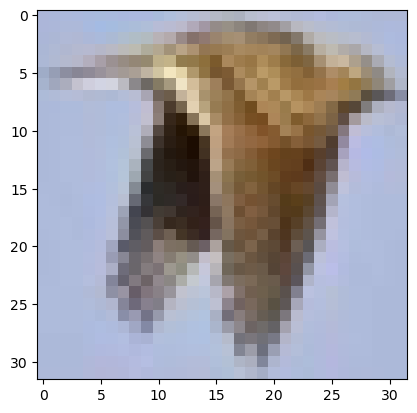

In [5]:
plt.imshow(X_train[123], cmap='gray')

In [6]:
classes= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship','truck']

In [7]:
classes[y_train[123][0]]

'bird'

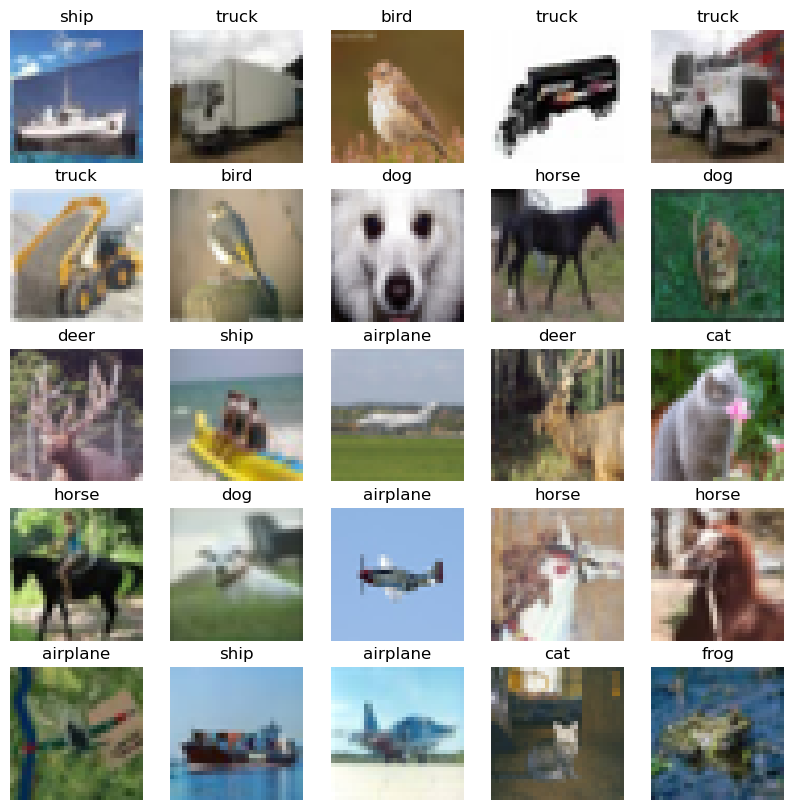

In [8]:
plt.figure(figsize=(10, 10))

for i in range(25):
    rand_index = int(np.random.randint(low=0, high=50000, size=1))
    plt.subplot(5, 5, i+1)
    plt.axis('off')
    plt.title(classes[int(y_train[rand_index])])
    plt.imshow(X_train[rand_index])

# Data Preprocessing

## Reshape the Data

In [9]:
# Normalization

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train / 255
X_test = X_test / 255

In [10]:
X_train[123].min(), X_train[123].max()

(0.003921569, 0.9529412)

# Changing Dtype of Target Feature to Categorical

In [11]:
y_Example = to_categorical(y_train)

y_test_cat = to_categorical(y_test, 10)
y_train_cat = to_categorical(y_train, 10)
np.min(y_Example == y_train_cat), y_test_cat.shape

(True, (10000, 10))

In [12]:
y_train_cat[123]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

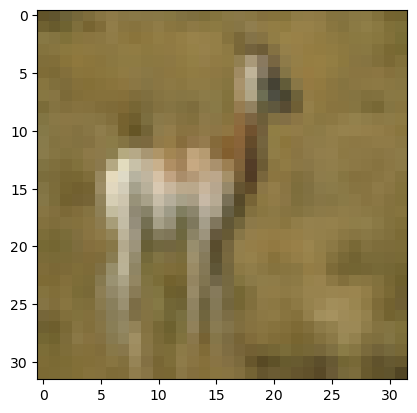

In [13]:
plt.imshow(X_train[58]);

# Convolutional Neural Network

## MODELLING - 1

In [14]:
# First Model

model1 = Sequential()
model1.add(Conv2D(32, kernel_size=(4, 4), input_shape=(32, 32, 3), activation='relu'))
model1.add(MaxPool2D(2, 2))
model1.add(Flatten())

model1.add(Dense(64, activation='relu'))
model1.add(Dense(10, activation='softmax'))

model1.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer = Adam(learning_rate = 1e-3))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 29, 29, 32)        1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 64)                401472    
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 403,690
Trainable params: 403,690
Non-trainable params: 0
__________________________________________________

# Early Stop

In [15]:
from tqdm import tqdm
# from keras_tqdm import TQDMCallback
from tqdm.keras import TqdmCallback

In [16]:
earlyStoppingCallback = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)
fitData1 = model1.fit(X_train, y_train_cat, batch_size=32, epochs=50, validation_data=(X_test, y_test_cat), 
                    callbacks=[earlyStoppingCallback, TqdmCallback()], verbose=True)
fitData1

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/50
1563/1563 [==============================] - 27s 17ms/step - loss: 1.4904 - accuracy: 0.4689 - val_loss: 1.3049 - val_accuracy: 0.5349
Epoch 2/50
1563/1563 [==============================] - 26s 16ms/step - loss: 1.2048 - accuracy: 0.5760 - val_loss: 1.1672 - val_accuracy: 0.5923
Epoch 3/50
1563/1563 [==============================] - 25s 16ms/step - loss: 1.0857 - accuracy: 0.6178 - val_loss: 1.0950 - val_accuracy: 0.6189
Epoch 4/50
1563/1563 [==============================] - 25s 16ms/step - loss: 1.0089 - accuracy: 0.6461 - val_loss: 1.0944 - val_accuracy: 0.6212
Epoch 5/50
1563/1563 [==============================] - 26s 16ms/step - loss: 0.9461 - accuracy: 0.6705 - val_loss: 1.1370 - val_accuracy: 0.6141
Epoch 6/50
1563/1563 [==============================] - 26s 16ms/step - loss: 0.9035 - accuracy: 0.6851 - val_loss: 1.0804 - val_accuracy: 0.6308
Epoch 7/50
1563/1563 [==============================] - 25s 16ms/step - loss: 0.8548 - accuracy: 0.7023 - val_loss: 1.0658 -

# Plotting Metrics of the Model

In [17]:
model1.metrics_names

['loss', 'accuracy']

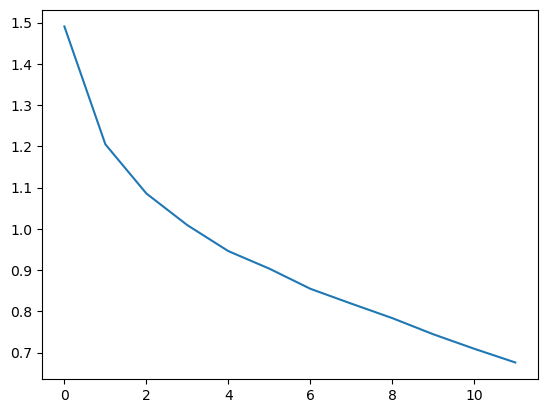

In [18]:
loss = model1.history.history['loss']
plt.plot(loss)
plt.show();

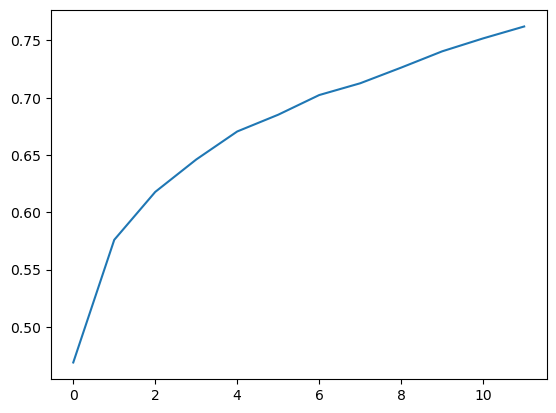

In [19]:
acc = model1.history.history['accuracy']
plt.plot(acc)
plt.show();

In [20]:
fitData1.history

{'loss': [1.4903846979141235,
  1.2048251628875732,
  1.085678219795227,
  1.0089284181594849,
  0.9460768103599548,
  0.9035465717315674,
  0.8547954559326172,
  0.8187975287437439,
  0.783666729927063,
  0.7445476651191711,
  0.7093906402587891,
  0.6762226819992065],
 'accuracy': [0.4689199924468994,
  0.5759599804878235,
  0.6177800297737122,
  0.6460599899291992,
  0.670520007610321,
  0.6851400136947632,
  0.7023000121116638,
  0.7125800251960754,
  0.7262600064277649,
  0.7404599785804749,
  0.7517600059509277,
  0.7621399760246277],
 'val_loss': [1.3048763275146484,
  1.1671664714813232,
  1.0949628353118896,
  1.0944087505340576,
  1.1370117664337158,
  1.0804499387741089,
  1.0657991170883179,
  1.061160683631897,
  1.056323528289795,
  1.107564926147461,
  1.1315984725952148,
  1.1663529872894287],
 'val_accuracy': [0.5349000096321106,
  0.5922999978065491,
  0.6189000010490417,
  0.6212000250816345,
  0.6140999794006348,
  0.6308000087738037,
  0.6322000026702881,
  0.63830

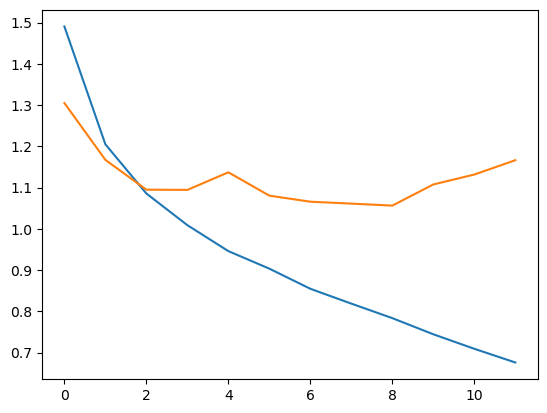

In [21]:
loss = fitData1.history['loss']
val_loss = fitData1.history['val_loss']
acc = fitData1.history['accuracy']
val_acc = fitData1.history['val_accuracy']

plt.plot(loss)
plt.plot(val_loss)
plt.show()

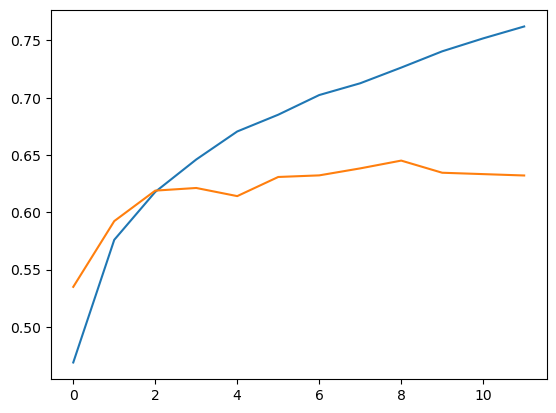

In [22]:
plt.plot(acc)
plt.plot(val_acc)
plt.show()

# Evaluation of the Model

In [23]:
import tensorflow_addons as tfa

ev = model1.evaluate(X_test, y_test_cat, 
                    callbacks=[tfa.callbacks.TQDMProgressBar()])

0/313           ETA: ?s - Evaluating

313/313 [==============================] - 2s 5ms/step - loss: 1.0563 - accuracy: 0.6451


# The Model Predict

In [24]:
y_preds = model1.predict(X_test)
y_preds

313/313 [==============================] - 2s 5ms/step


array([[3.6663027e-03, 4.8186778e-04, 9.0992428e-02, ..., 1.9788237e-03,
        8.9105428e-04, 2.8889024e-05],
       [5.2576023e-03, 9.5351940e-01, 9.1710331e-07, ..., 1.0881553e-09,
        4.0717784e-02, 5.0366542e-04],
       [1.6805901e-01, 2.9406166e-01, 3.2190040e-02, ..., 1.4506845e-02,
        2.7550370e-01, 2.0054401e-01],
       ...,
       [2.9246157e-04, 9.7967677e-06, 9.4741791e-02, ..., 2.1644519e-01,
        1.7407782e-06, 1.2012848e-05],
       [9.2680547e-03, 8.6989003e-01, 1.4222019e-03, ..., 7.1796696e-03,
        5.9815458e-05, 1.5789257e-04],
       [1.5112704e-05, 8.8946178e-04, 1.9638417e-03, ..., 9.6876079e-01,
        1.9364231e-06, 2.5802606e-03]], dtype=float32)

In [25]:
y_pred = np.argmax(y_preds, axis=1)
y_pred[0]

3

In [26]:
np.argmax(y_preds, axis=1)

array([3, 1, 1, ..., 5, 1, 7])

In [27]:
y_test_cat2 = np.argmax(y_test_cat, axis=1)

# Report and Heatmap

In [28]:
print(classification_report(y_test_cat2, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.70      0.68      1000
           1       0.72      0.79      0.75      1000
           2       0.49      0.51      0.50      1000
           3       0.52      0.42      0.46      1000
           4       0.59      0.56      0.58      1000
           5       0.56      0.54      0.55      1000
           6       0.70      0.75      0.72      1000
           7       0.64      0.78      0.71      1000
           8       0.83      0.68      0.75      1000
           9       0.73      0.70      0.72      1000

    accuracy                           0.65     10000
   macro avg       0.65      0.65      0.64     10000
weighted avg       0.65      0.65      0.64     10000



In [29]:
confusion_matrix(y_test_cat2, y_pred)

array([[702,  42,  76,  18,  20,   7,  19,  27,  49,  40],
       [ 26, 791,  17,   8,   6,   7,  17,  12,  21,  95],
       [ 69,  11, 514,  50,  95,  88,  74,  75,  11,  13],
       [ 25,  16,  89, 421,  93, 180,  85,  71,   7,  13],
       [ 31,   4, 109,  53, 564,  38,  60, 127,   8,   6],
       [ 13,   7,  97, 150,  60, 543,  38,  72,  11,   9],
       [  7,  15,  71,  52,  47,  34, 749,  12,   3,  10],
       [ 12,   6,  37,  29,  47,  55,   6, 784,   4,  20],
       [117,  77,  18,  17,  10,   8,  14,  10, 679,  50],
       [ 50, 137,  14,  15,  12,   8,  12,  27,  21, 704]])

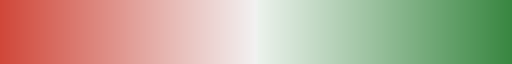

In [30]:
cmap = sns.diverging_palette(15, 130, as_cmap=True)
cmap

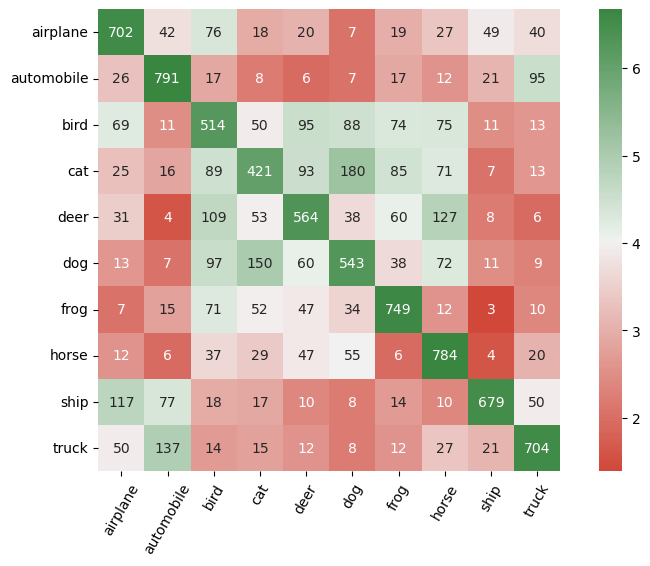

In [31]:
cm = confusion_matrix(y_test_cat2, y_pred)

plt.figure(figsize=(10, 6))
# sns.heatmap(cm, annot=True, fmt='d');

sns.heatmap(np.log1p(cm), annot=cm, cmap=cmap, fmt='d', 
            xticklabels=classes, yticklabels=classes, square=True)
plt.xticks(rotation=60)
plt.show()

## MODELLING - 2

In [32]:
model2 = Sequential()

model2.add(Conv2D(64, kernel_size=(4, 4), input_shape=(X_train.shape[1:]), activation='relu', padding='same'))
model2.add(Conv2D(32, kernel_size=(4, 4), activation='relu', padding='same'))
model2.add(MaxPool2D((2, 2)))
model2.add(Dropout(0.5))  

model2.add(Conv2D(32, kernel_size=(4, 4), activation='relu', padding='same'))
model2.add(MaxPool2D((2, 2)))
model2.add(Dropout(0.5))  

model2.add(Flatten())

model2.add(Dense(64, activation='relu'))
model2.add(Dense(10, activation='softmax'))

model2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer="adam")

In [33]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        32800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 32)        16416     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                  

In [ ]:
bar = tfa.callbacks.TQDMProgressBar()

fitData2 = model2.fit(X_train, y_train_cat, batch_size=32, epochs=50, validation_data=(X_test, y_test_cat),
                      callbacks=[earlyStoppingCallback, bar], verbose=True)
fitData2

Training:   0%|           0/50 ETA: ?s,  ?epochs/s

Epoch 1/50


0/1563           ETA: ?s - 

Epoch 1/50
1563/1563 [==============================] - 337s 215ms/step - loss: 1.6975 - accuracy: 0.3811 - val_loss: 1.4955 - val_accuracy: 0.4777
Epoch 2/50


0/1563           ETA: ?s - 

Epoch 2/50
1563/1563 [==============================] - 333s 213ms/step - loss: 1.3866 - accuracy: 0.4982 - val_loss: 1.2975 - val_accuracy: 0.5662
Epoch 3/50


0/1563           ETA: ?s - 

Epoch 3/50
1563/1563 [==============================] - 332s 212ms/step - loss: 1.2694 - accuracy: 0.5437 - val_loss: 1.2193 - val_accuracy: 0.5863
Epoch 4/50


0/1563           ETA: ?s - 

Epoch 4/50
1563/1563 [==============================] - 333s 213ms/step - loss: 1.1948 - accuracy: 0.5731 - val_loss: 1.1600 - val_accuracy: 0.5896
Epoch 5/50


0/1563           ETA: ?s - 

Epoch 5/50
1563/1563 [==============================] - 332s 212ms/step - loss: 1.1380 - accuracy: 0.5920 - val_loss: 1.0729 - val_accuracy: 0.6284
Epoch 6/50


0/1563           ETA: ?s - 

Epoch 6/50
1563/1563 [==============================] - 332s 213ms/step - loss: 1.0918 - accuracy: 0.6126 - val_loss: 1.0127 - val_accuracy: 0.6600
Epoch 7/50


0/1563           ETA: ?s - 

Epoch 7/50
1563/1563 [==============================] - 330s 211ms/step - loss: 1.0593 - accuracy: 0.6247 - val_loss: 1.0062 - val_accuracy: 0.6617
Epoch 8/50


0/1563           ETA: ?s - 

Epoch 8/50
1563/1563 [==============================] - 329s 211ms/step - loss: 1.0258 - accuracy: 0.6346 - val_loss: 0.9619 - val_accuracy: 0.6701
Epoch 9/50


0/1563           ETA: ?s - 

Epoch 9/50
1563/1563 [==============================] - 336s 215ms/step - loss: 1.0003 - accuracy: 0.6432 - val_loss: 0.9442 - val_accuracy: 0.6795
Epoch 10/50


0/1563           ETA: ?s - 

Epoch 10/50
1563/1563 [==============================] - 333s 213ms/step - loss: 0.9801 - accuracy: 0.6518 - val_loss: 0.9106 - val_accuracy: 0.6998
Epoch 11/50


0/1563           ETA: ?s - 

Epoch 11/50
1563/1563 [==============================] - 333s 213ms/step - loss: 0.9585 - accuracy: 0.6595 - val_loss: 0.9035 - val_accuracy: 0.6925
Epoch 12/50


0/1563           ETA: ?s - 

Epoch 12/50
1563/1563 [==============================] - 337s 216ms/step - loss: 0.9449 - accuracy: 0.6655 - val_loss: 0.8882 - val_accuracy: 0.6981
Epoch 13/50


0/1563           ETA: ?s - 

Epoch 13/50
 211/1563 [===>..........................] - ETA: 4:45 - loss: 0.9434 - accuracy: 0.6611

In [ ]:
loss2 = fitData2.history['loss']
val_loss2 = fitData2.history['val_loss']
acc2 = fitData2.history['accuracy']
val_acc2 = fitData2.history['val_accuracy']

plt.plot(loss2)
plt.plot(val_loss2)
plt.show()

In [ ]:
plt.plot(acc2)
plt.plot(val_acc2)
plt.show()

In [ ]:
ev2 = model2.evaluate(X_test, y_test_cat, callbacks=[tfa.callbacks.TQDMProgressBar()])

In [ ]:
y_preds2 = model2.predict(X_test)
y_preds2

In [ ]:
y_pred2 = np.argmax(y_preds2, axis=1)
y_pred2

In [ ]:
y_test_cat2_2 = np.argmax(y_test_cat, axis=1)

In [ ]:
print(classification_report(y_test_cat2_2, y_pred2))

In [ ]:
cm2 = confusion_matrix(y_test_cat2_2, y_pred2)

plt.figure(figsize=(10, 6))
# sns.heatmap(cm, annot=True, fmt='d');

sns.heatmap(np.log1p(cm2), annot=cm2, cmap=cmap, fmt='d',xticklabels=classes, yticklabels=classes, square=True)
plt.xticks(rotation=60)
plt.show()

## MODELLING - 3

In [ ]:
from tensorflow.keras.layers import BatchNormalization

In [ ]:
model3 = Sequential()

model3.add(Conv2D(16, kernel_size=(4, 4), input_shape=(X_train.shape[1:]), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(Conv2D(32, kernel_size=(4, 4), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPool2D((2, 2)))

model3.add(Conv2D(64, kernel_size=(4, 4), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(Conv2D(128, kernel_size=(4, 4), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPool2D((2, 2)))

model3.add(Conv2D(64, kernel_size=(4, 4), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(Conv2D(32, kernel_size=(4, 4), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPool2D((2, 2)))

model3.add(Flatten())

model3.add(Dense(64, activation='relu'))
model3.add(Dense(10, activation='softmax'))

model3.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate = 0.01))
model3.summary()

In [ ]:
fitData3 = model3.fit(X_train, y_train_cat, batch_size=16, epochs=50, validation_data=(X_test, y_test_cat),
                      callbacks=[earlyStoppingCallback, TqdmCallback()], verbose=True)
fitData3

In [ ]:
loss3 = fitData3.history['loss']
val_loss3 = fitData3.history['val_loss']
acc3 = fitData3.history['accuracy']
val_acc3 = fitData3.history['val_accuracy']

plt.plot(loss3)
plt.plot(val_loss3)
plt.show()

In [ ]:
plt.plot(acc3)
plt.plot(val_acc3)
plt.show()

In [ ]:
ev3 = model3.evaluate(X_test, y_test_cat, callbacks=[tfa.callbacks.TQDMProgressBar()])

In [ ]:
y_preds3 = model3.predict(X_test)
y_preds3

In [ ]:
y_pred3 = np.argmax(y_preds3, axis=1)
y_pred3

In [ ]:
y_test_cat2_3 = np.argmax(y_test_cat, axis=1)

In [ ]:
print(classification_report(y_test_cat2_3, y_pred3))

In [ ]:
cm3 = confusion_matrix(y_test_cat2_3, y_pred3)

plt.figure(figsize=(10, 6))
# sns.heatmap(cm, annot=True, fmt='d');

sns.heatmap(np.log1p(cm3), annot=cm3, cmap=cmap, fmt='d',xticklabels=classes, yticklabels=classes, square=True)
plt.xticks(rotation=60)
plt.show()